<a href="https://colab.research.google.com/github/Yashsharma009/Lipread_lipnet/blob/main/LipNet_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install and Import Dependencies

In [ ]:
!pip install gdown imageio

In [ ]:
import os
import cv2
import tensorflow as tf
import gdown #get data from GDrive
import numpy as np
import matplotlib.pyplot as plt
import imageio #render post processed output a lot better (better while working w/ videos)
from typing import List #List type annotations

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#prevents machine from sucking up all memory and get out of memory errors
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
  pass

In [ ]:
url= "https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL"
output = 'data.zip'
gdown.download(url,output,quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:02<00:00, 211MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> List[float]: #takes path of video and outputs a string of floats

    cap = cv2.VideoCapture(path) #create cv2 instance
    #loop through each one of these and store the extracted frames in an array
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:]) #only takes the cropped lip part of each frame (static slicing)
        #An advanced way is to use Dlib as used in the original LipNet paper.
    cap.release()

    #scaling each frame
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
#creating vocab- every single character that is expected to be encountered in our annotations
vocab= [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
#originally from the keras ctc Automatic Speech Recognition tutorial paper
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="") #converts char to num
num_to_char = tf.keras.layers.StringLookup(
    vocabulary= char_to_num.get_vocabulary(), oov_token="", invert=True) #converts num to char


print(
    f"the vocabulary is : {char_to_num.get_vocabulary()}\n"
    f"size is : {char_to_num.vocabulary_size()}"
)

the vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ']
size is : 40


In [ ]:
#load up our alignments
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]


In [ ]:
#returning the preprocessed videos and preprocessed alignments together from their respective paths

def load_data(path:str):
  path = bytes.decode(path.numpy())
  filename = path.split('/')[-1].split('.')[0] #colab
  #file_name = path.split('\\')[-1].split('.')[0]  for windows.
  video_path = os.path.join('data','s1',f'{filename}.mpg')
  alignment_path = os.path.join('data','alignments','s1',f'{filename}.align')
  frames=load_video(video_path)
  alignments = load_alignments(alignment_path)

  return frames, alignments

In [ ]:
test_path = '/data/s1/bbal6n.mpg'

In [ ]:
#filename
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'/data/s1/bbal6n'

In [ ]:
frames,alignments = load_data(tf.convert_to_tensor(test_path))

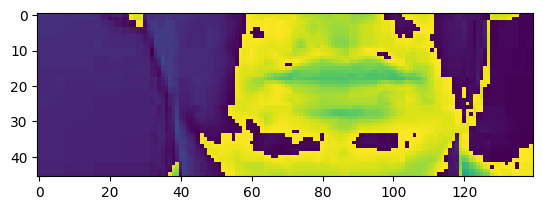

In [ ]:
plt.imshow(frames[0])

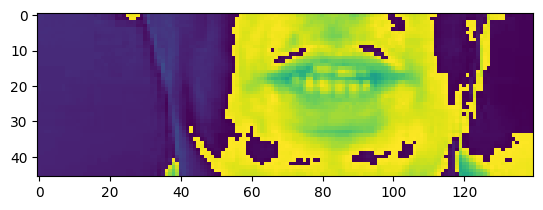

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in alignments])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str)->List[str]:
  result=tf.py_function(load_data, [path], (tf.float32,tf.int64))
  return result


In [ ]:
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(500,reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
#Added for split
train= data.take(450)
test= data.skip(450)

In [ ]:
len(train)

450

In [ ]:
len(test)

50

In [ ]:

test1= data.as_numpy_iterator()

In [ ]:
val= test1.next(); val[0]

array([[[[[ 0.6747613 ],
          [ 1.0871154 ],
          [ 1.1995757 ],
          ...,
          [ 0.41235414],
          [ 0.41235414],
          [ 0.41235414]],

         [[ 0.78722155],
          [ 0.6747613 ],
          [ 0.78722155],
          ...,
          [ 0.41235414],
          [ 0.41235414],
          [ 0.41235414]],

         [[ 1.0871154 ],
          [ 1.0496287 ],
          [ 0.74973476],
          ...,
          [ 0.41235414],
          [ 0.37486738],
          [ 0.37486738]],

         ...,

         [[ 1.0496287 ],
          [ 1.0496287 ],
          [ 1.0496287 ],
          ...,
          [ 0.14994696],
          [ 0.14994696],
          [ 0.14994696]],

         [[ 1.012142  ],
          [ 1.012142  ],
          [ 1.012142  ],
          ...,
          [ 0.14994696],
          [ 0.14994696],
          [ 0.14994696]],

         [[ 1.012142  ],
          [ 1.012142  ],
          [ 0.9746552 ],
          ...,
          [ 0.14994696],
          [ 0.14994696],
          

In [ ]:
imageio.mimsave('animation.gif',val[0][0],fps=10)
#Cool function alert! This converts the first video instance out of the 2 in the batch to a gif of 10 fps.

TypeError: ignored

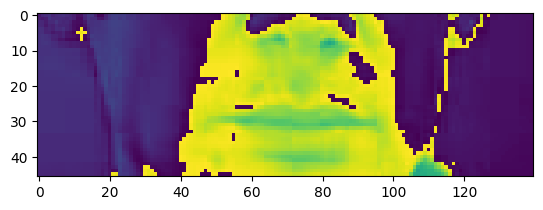

In [ ]:
# 0/1: videos/alignments, 0/1: first or second video, 0-74: frames of video 1.
plt.imshow(val[0][0][0])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set blue by n eight sp please'>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv3D,LSTM, Dropout,Bidirectional, Activation, SpatialDropout3D, BatchNormalization, MaxPool3D,Reshape, Flatten,TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
char_to_num.vocabulary_size()

40

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 9s 9s/step


In [ ]:
yhat[0].shape

(75, 41)

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b"3333333333!!!!!!!!!!!!!!!!!!!44444!!!!444444444444444444444444444444444''??">

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

In [ ]:
def scheduler(epoch,lr):
  if epoch<30:
    return lr
  else:
    return lr*tf.math.exp(-0.1)

In [ ]:
#CTC LOSS - this block of code has been picked up from Automatic Speech Recognition using CTC paper.
def CTCLoss(y_true,y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
  input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
  label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

  input_length=input_length* tf.ones(shape=(batch_len,1),dtype='int64')
  label_length = label_length* tf.ones(shape=(batch_len,1), dtype='int64')

  loss = tf.keras.backend.ctc_batch_cost(y_true,y_pred,input_length, label_length)
  return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),loss =CTCLoss)

In [ ]:
checkpoint_callback= ModelCheckpoint(os.path.join('models','checkpoint'),monitor='loss', save_weights_only=True)


In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(data)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback], )

Epoch 1/100
1/1 [==============================] - 2s 2s/step
Original: bin green with b seven again
Prediction: la e e e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set green at v five soon
Prediction: la e e e e on
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 711s 2s/step - loss: 84.1120 - val_loss: 68.5376 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - 0s 234ms/step
Original: lay white at e eight now
Prediction: l e e e e n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: set blue by h five again
Prediction: l e e e e n
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
450/450 [==============================] - 672s 1s/step - loss: 75.7219 - val_loss: 71.7958 - lr: 1.0000e-04
Epoch 3

UnknownError: ignored